# DNN Classifiers

In [1]:
import pickle
import numpy as np
import pandas as pd
import scikitplot as skplt
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction import stop_words
from keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics

# Keras
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
from tensorflow.estimator import DNNClassifier
from tensorflow.keras.preprocessing.text import Tokenizer, one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from tensorflow.keras import utils
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

Using TensorFlow backend.


### Load data

In [2]:
df = pd.read_csv("../data/mixed_data_1200.csv", sep=';')
df = df.drop(["Unnamed: 0"],axis=1)
df.head(5)

,target,text
0,0,@Starrbby too bad I won't be around I lost my ...
1,0,amazon s3 plugin not worked in my website . it...
2,0,The Hoyts Distribution NZ website isn't workin...
3,0,dang won't be able to get to any workshops run...
4,0,Tried to install a Twitter-application on my p...


In [3]:
df.head(5)
#converts whitespaces
trb_nan_idx = df[pd.isnull(df['text'])].index.tolist()
df.loc[trb_nan_idx, 'text'] = ' '
X_load = df["text"]
Y_load = df["target"]

#0 = negative, 2 = neutral, 4 = positive
dicc = {0:0,2:1,4:2}
Y_load = Y_load.map(dicc)

### Split data into train/test set

In [4]:
X_traink ,X_testk, y_traink, y_testk = train_test_split(X_load,Y_load,test_size=0.2,random_state=42,shuffle=True)
y_test = y_testk

### Tokenize data

In [5]:
tokenizer = Tokenizer(lower=True,filters = "!\"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n", split = " ")
tokenizer.fit_on_texts(X_traink)

In [6]:
#observe tokenizer properties
#print(tokenizer.word_counts) #word_counts: A dictionary of words and their counts.
#print(tokenizer.document_count) #document_count:An integer count of the total number of documents that were used to fit the Tokenizer.
#print(tokenizer.word_index.keys()) #word_index: A dictionary of words and their uniquely assigned integers.
#print(tokenizer.word_docs) #word_docs: A dictionary of words and how many documents each appeared in.

## Preliminary inspection of the data 

In [7]:
# run only once
X_traink = tokenizer.texts_to_sequences(X_traink)
X_testk = tokenizer.texts_to_sequences(X_testk)

In [8]:
#average tweet length
average_length = np.mean([len(x) for x in X_traink])
#median tweet length
median_length = sorted([len(x) for x in X_traink])[len(X_traink) // 2]
print('The average tweet length is {} and the median is {} '.format(average_length,median_length))

The average tweet length is 12.096299093655588 and the median is 11 


## Pedding

In [9]:
max_sequence_length = 80
X_traink = pad_sequences(X_traink,maxlen=max_sequence_length,padding="post", truncating='post',dtype='int32',value=0.)
X_testk = pad_sequences(X_testk,maxlen=max_sequence_length,padding="post", truncating='post',dtype='int32',value=0.)

In [10]:
X_traink.shape

(2648, 80)

In [11]:
print(X_traink)

[[  43   52  174 ...    0    0    0]
 [   4   32  101 ...    0    0    0]
 [ 151   13    2 ...    0    0    0]
 ...
 [   5  334  149 ...    0    0    0]
 [6384  175   46 ...    0    0    0]
 [ 354  666   12 ...    0    0    0]]


### Convert Data to fit for softmax activation function

In [12]:
num_classes = max(y_traink+1)
print(num_classes)
y_traink = tf.keras.utils.to_categorical(y_traink,num_classes=3)
y_testk = tf.keras.utils.to_categorical(y_testk,num_classes=3)

3


### First DNN

In [13]:
max_words = 6386
hidden_size = 5
epochs = 10
batch_size = 20

model1 = Sequential()
model1.add(Embedding(max_words, hidden_size, input_length=max_sequence_length))
model1.add(LSTM(hidden_size, activation='relu', dropout=0.4, recurrent_dropout=0.4))
model1.add(Dense(3, activation='softmax'))
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [14]:
history0 = model1.fit(X_traink, y_traink, epochs=epochs, shuffle=True,validation_split=0.2)

W0706 08:52:08.280646 4580894144 deprecation.py:323] From /Users/ChrisChross/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 2118 samples, validate on 530 samples
Epoch 1/10
2118/2118 [==============================] - 4s 2ms/sample - loss: 1.0985 - accuracy: 0.3234 - val_loss: 1.0983 - val_accuracy: 0.3528
Epoch 2/10
2118/2118 [==============================] - 3s 1ms/sample - loss: 1.0977 - accuracy: 0.3329 - val_loss: 1.0982 - val_accuracy: 0.3528
Epoch 3/10
2118/2118 [==============================] - 3s 1ms/sample - loss: 1.0978 - accuracy: 0.3352 - val_loss: 1.0982 - val_accuracy: 0.3528
Epoch 4/10
2118/2118 [==============================] - 4s 2ms/sample - loss: 1.0970 - accuracy: 0.3508 - val_loss: 1.0983 - val_accuracy: 0.3528
Epoch 5/10
2118/2118 [==============================] - 4s 2ms/sample - loss: 1.0969 - accuracy: 0.3277 - val_loss: 1.0984 - val_accuracy: 0.3528
Epoch 6/10
2118/2118 [==============================] - 5s 2ms/sample - loss: 1.0967 - accuracy: 0.3451 - val_loss: 1.0986 - val_accuracy: 0.3528
Epoch 7/10
2118/2118 [==============================] - 5s 2ms/sample - loss:

In [15]:
loss, acc = model1.evaluate(X_testk, y_testk)
print('Single layer model -- ACC {} -- LOSS {}'.format(acc, loss))

662/662 [==============================] - 1s 982us/sample - loss: 1.0945 - accuracy: 0.3263
Single layer model -- ACC 0.3262839913368225 -- LOSS 1.0945163590670353


### Secound DNN

In [16]:
max_words = 6386
hidden_size = 20
epochs = 10
batch_size = 10

model2 = Sequential()
model2.add(Embedding(max_words, hidden_size,input_length=max_sequence_length))
model2.add(LSTM(hidden_size, activation='relu', dropout=0.4, recurrent_dropout=0.2, return_sequences=True))
model2.add(LSTM(hidden_size, activation='relu', dropout=0.4, recurrent_dropout=0.2))
model2.add(Dense(3, activation='softmax'))
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [17]:
history2 = model2.fit(X_traink, y_traink, epochs=epochs, shuffle=True, validation_split=0.1)

Train on 2383 samples, validate on 265 samples
Epoch 1/10
2383/2383 [==============================] - 9s 4ms/sample - loss: 1.0983 - accuracy: 0.3407 - val_loss: 1.0977 - val_accuracy: 0.3283
Epoch 2/10
2383/2383 [==============================] - 7s 3ms/sample - loss: 1.0976 - accuracy: 0.3458 - val_loss: 1.0976 - val_accuracy: 0.3283
Epoch 3/10
2383/2383 [==============================] - 9s 4ms/sample - loss: 1.0975 - accuracy: 0.3512 - val_loss: 1.0978 - val_accuracy: 0.3283
Epoch 4/10
2383/2383 [==============================] - 11s 4ms/sample - loss: 1.0977 - accuracy: 0.3483 - val_loss: 1.0974 - val_accuracy: 0.3283
Epoch 5/10
2383/2383 [==============================] - 6s 3ms/sample - loss: 1.0974 - accuracy: 0.3487 - val_loss: 1.0975 - val_accuracy: 0.3283
Epoch 6/10
2383/2383 [==============================] - 6s 2ms/sample - loss: 1.0974 - accuracy: 0.3361 - val_loss: 1.0974 - val_accuracy: 0.3283
Epoch 7/10
2383/2383 [==============================] - 6s 2ms/sample - loss

In [18]:
loss, acc = model2.evaluate(X_testk, y_testk)
print('Single layer model -- ACC {} -- LOSS {}'.format(acc, loss))

662/662 [==============================] - 1s 2ms/sample - loss: 1.0936 - accuracy: 0.3912
Single layer model -- ACC 0.39123865962028503 -- LOSS 1.093593380602465


### Predict
use the unlabled data

In [19]:
xxx = ["Today my PC crashed what a shit I can not work I am so stressed"]
xxx1 = tokenizer.texts_to_sequences(xxx)
xxx2 = pad_sequences(xxx1,maxlen=max_sequence_length,padding="post", truncating='post',dtype='int32',value=0.)
pred = model2.predict_classes(xxx2)
pred

array([0])

In [20]:
#predict crisp classes for test set
predictions1 = model1.predict_classes(X_testk, verbose=0)
predictions1_probs = model1.predict(X_testk, verbose=0)
predictions1.shape

(662,)

In [21]:
predictions2 = model2.predict_classes(X_testk, verbose=0)
predictions2_probs = model2.predict(X_testk, verbose=0)
predictions2.shape

(662,)

<Figure size 432x288 with 0 Axes>

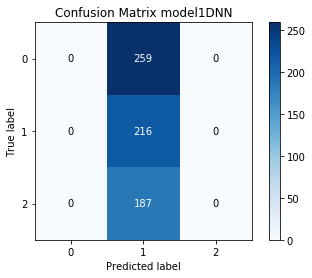

In [22]:
#plot CM
plt.figure()
skplt.metrics.plot_confusion_matrix(y_test,predictions1,normalize=False)
plt.title("Confusion Matrix model1DNN")
plt.show()

<Figure size 432x288 with 0 Axes>

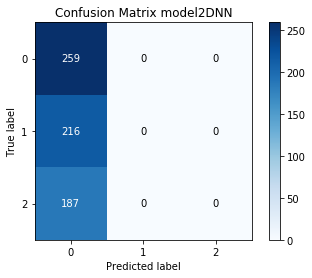

In [23]:
# reduce to 1d array
#yhat2_probs = predictions2_probs[:, 0]
#yhat2_classes = predictions2[:, 0]
#yhat2_classes.shape

#plot CM
plt.figure()
skplt.metrics.plot_confusion_matrix(y_test,predictions2,normalize=False)
plt.title("Confusion Matrix model2DNN")
plt.show()

### Evaluate

In [30]:
print(metrics.classification_report(y_test, predictions1,target_names=["technostress","neutral","positive"]))
report = metrics.classification_report(y_test, predictions1,target_names=["technostress","neutral","positive"],output_dict=True)
reportdf = pd.DataFrame(report).transpose()
#print(reportdf.to_latex())


              precision    recall  f1-score   support

technostress       0.00      0.00      0.00       259
     neutral       0.33      1.00      0.49       216
    positive       0.00      0.00      0.00       187

   micro avg       0.33      0.33      0.33       662
   macro avg       0.11      0.33      0.16       662
weighted avg       0.11      0.33      0.16       662



In [25]:
# list all data in history
print(history0.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [26]:
# list all data in history
print(history2.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


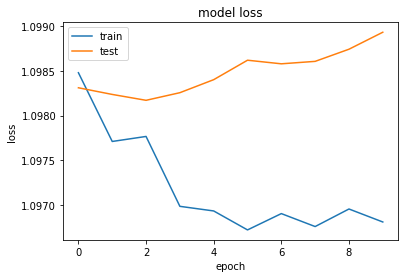

In [27]:
# summarize history for loss
plt.plot(history0.history['loss'])
plt.plot(history0.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

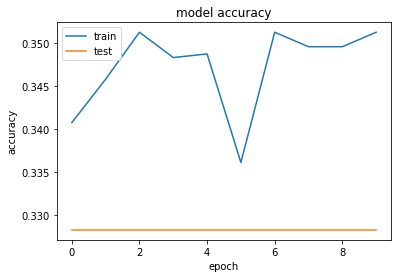

In [28]:
# summarize history for accuracy
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()